In [26]:
from RADARDataCapture import FMCWRADARDataCapture
from MOCAPDataCapture import MOCAPDataCapture
from FPDataCapture import FPDataCapture
import h5py
import os
import numpy as np
import pandas as pd
import imageio
import matplotlib.pyplot as plt
from datetime import datetime
import statistics
from matplotlib import animation
import ast

In [8]:

def calculate_angular_velocity(time_step, angles):
    return (angles.diff() / time_step).fillna(0)  # Fill NaN for the first row

def process_csv_files(source_folder, target_folder, time_step=0.01):
    os.makedirs(target_folder, exist_ok=True)
    
    for root, dirs, files in os.walk(source_folder):
        for file in files:
            if file.endswith('.csv') and ('MNTRL' in file or 'MNTRR' in file):
                print(file)
                file_path = os.path.join(root, file)
                try:
                    df = pd.read_csv(file_path, encoding='utf-8')
                except UnicodeDecodeError:
                    df = pd.read_csv(file_path, encoding='ISO-8859-1')  # Attempt with a different encoding
                
                # Print the first few rows of the DataFrame
                print(df.head())
                selected_columns = df.iloc[:, 1:4]  # Adjusted for Python indexing
                print(selected_columns.head())
                
                knee_angle_column = 'Knee_R_angle' if 'MNTRL' in file else 'Knee_L_angle'
                
                # Check if the knee angle column exists before attempting to use it
                if knee_angle_column in df.columns:
                    selected_columns[knee_angle_column] = df[knee_angle_column]
                    selected_columns['Angular_Velocity'] = calculate_angular_velocity(time_step, df[knee_angle_column])
                else:
                    print(f"Warning: Column {knee_angle_column} not found in file {file}. Skipping this file.")
                    continue
                
                new_file_path = os.path.join(target_folder, f"{file}".replace("_pos",""))
                selected_columns.to_csv(new_file_path, index=False)

# Example usage
source_folder = '/Volumes/FourTBLaCie/all_MOCAP_data'
target_folder = '/Volumes/FourTBLaCie/Yoga_Study_MOCAP_FUFD'
process_csv_files(source_folder, target_folder)


16_MNTRL_MC_V1_pos.csv
   frame  time  participant_id   pose  Actuator_pos_X  Actuator_pos_Y  \
0      0  0.00              16  Tpose        5075.960         403.992   
1      1  0.01              16  Tpose        5075.986         404.006   
2      2  0.02              16  Tpose        5075.957         403.998   
3      3  0.03              16  Tpose        5076.003         404.002   
4      4  0.04              16  Tpose        5075.988         404.017   

   Actuator_pos_Z  Wrist_R_pos_X  Wrist_R_pos_Y  Wrist_R_pos_Z  ...  \
0        1255.807        973.948       -300.668       1408.050  ...   
1        1255.808        973.999       -300.679       1408.052  ...   
2        1255.804        974.072       -300.683       1408.047  ...   
3        1255.818        974.164       -300.707       1408.080  ...   
4        1255.791        974.211       -300.668       1408.065  ...   

   Elbow_L_angle  Knee_R_angle  Knee_L_angle  Shoulder_R_angle  \
0     171.447499    169.590495    167.095178 

Find T_stable and T_start_down in MOCAP Knee Data

In [4]:
csv_path = "/Volumes/FourTBLaCie/Yoga_Study_MOCAP_FUFD/01_MNTRL_MC_V1.csv"
df = pd.read_csv(csv_path)

print(df.head())

signal = df['Knee_R_angle']

   time  participant_id   pose  Knee_R_angle  Angular_Velocity
0  0.00               1  Tpose    178.147270          0.000000
1  0.01               1  Tpose    178.131512         -1.575779
2  0.02               1  Tpose    178.178322          4.680998
3  0.03               1  Tpose    178.091589         -8.673316
4  0.04               1  Tpose    178.045519         -4.607004


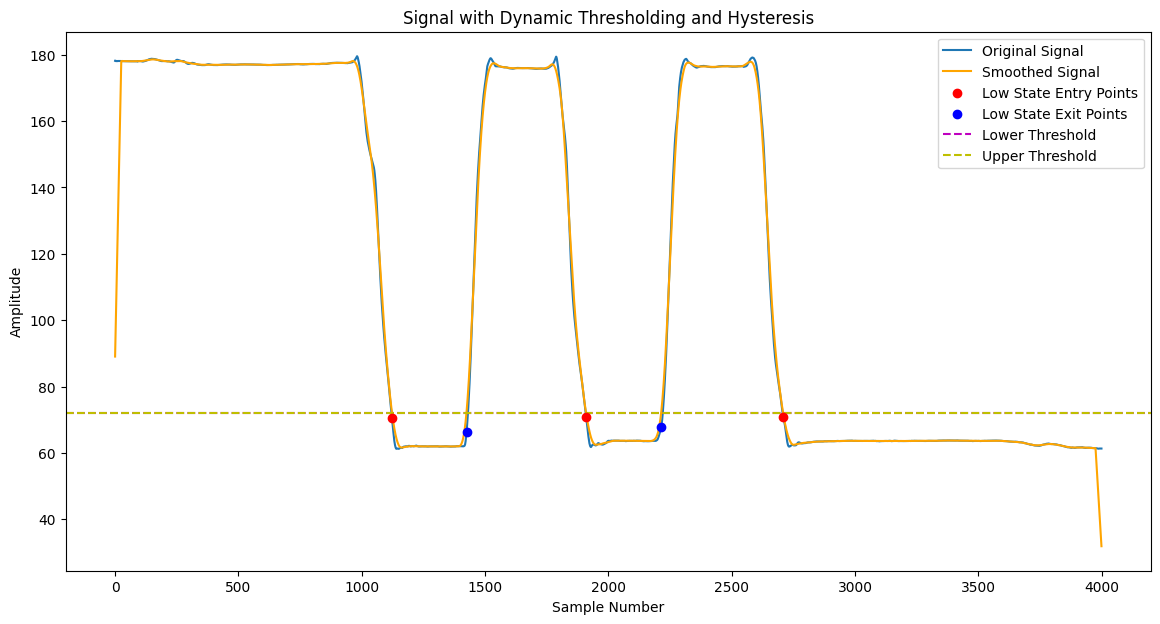

Low state entry points: [1123, 1910, 2709]
Low state exit points: [1425, 2214]


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# # Assuming 'signal' is a NumPy array containing the signal values.
# # Here we would load your signal data. For demonstration, let's create a dummy signal:
# signal = np.random.normal(0, 1, 1000)  # A dummy signal with noise
# signal[200:300] = -10  # Simulate a low state
# signal[500:600] = -10  # Another low state


# Smoothing the signal with a simple moving average
def smooth_signal(signal, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(signal, window, 'same')

# Function to apply dynamic thresholding with hysteresis
def dynamic_thresholding_with_hysteresis(signal, FU=700, FD=3300, window_size=50, std_factor=.8, start_index=700, end_index=3300):
    smoothed_signal = smooth_signal(signal, window_size)
    mean_signal = np.mean(smoothed_signal[start_index:end_index])
    std_signal = np.std(smoothed_signal[start_index:end_index])

    # Dynamic thresholds
    lower_threshold = mean_signal - (std_signal * std_factor)
    # Make the upper threshold stricter (closer to the lower threshold) for earlier exit detection
    upper_threshold = mean_signal - (std_signal * std_factor) 

    low_states_entry = []
    low_states_exit = []
    in_low_state = False

    for i, value in enumerate(smoothed_signal[FU:FD], start=FU):
        if not in_low_state and value < lower_threshold:
            low_states_entry.append(i)
            in_low_state = True
        elif in_low_state and value > upper_threshold:
            low_states_exit.append(i)
            in_low_state = False

    return low_states_entry, low_states_exit, lower_threshold, upper_threshold

# Apply the thresholding with hysteresis
smoothed_signal = smooth_signal(signal, window_size=50)
low_states_entry, low_states_exit, lower_threshold, upper_threshold = dynamic_thresholding_with_hysteresis(signal)

# Plotting the results
plt.figure(figsize=(14, 7))
plt.plot(signal, label='Original Signal')
plt.plot(smoothed_signal, label='Smoothed Signal', color='orange')
plt.scatter(low_states_entry, signal[low_states_entry], color='red', zorder=3, label='Low State Entry Points')
plt.scatter(low_states_exit, signal[low_states_exit], color='blue', zorder=3, label='Low State Exit Points')
plt.axhline(y=lower_threshold, color='m', linestyle='--', label='Lower Threshold')
plt.axhline(y=upper_threshold, color='y', linestyle='--', label='Upper Threshold')
plt.legend()
plt.title('Signal with Dynamic Thresholding and Hysteresis')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

# Print the transition points
print("Low state entry points:", low_states_entry)
print("Low state exit points:", low_states_exit)


In [27]:
import numpy as np

def dynamic_thresholding_with_hysteresis(signal, adjust_std, FU=700, FD=3300, window_size=50, start_index=700, end_index=3300):
    smoothed_signal = smooth_signal(signal, window_size)
    mean_signal = np.mean(smoothed_signal[start_index:end_index])
    std_signal = np.std(smoothed_signal[start_index:end_index])

    if adjust_std:
        # Fixed std_factor for 'True' condition
        std_factor = 0.75
        lower_threshold = mean_signal - (std_signal * std_factor)
        upper_threshold = mean_signal - (std_signal * std_factor)

        low_states_entry, low_states_exit = find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold)
        low_states_exit = []
        print(f"Used STD Factor: {std_factor} (Fixed)")
    else:
        # Initialize variables for iteration
        std_factor = 0.7
        best_low_states_entry = []
        best_low_states_exit = []
        best_std_factor = std_factor

        while std_factor < .8:
            lower_threshold = mean_signal - (std_signal * std_factor)
            upper_threshold = mean_signal - (std_signal * std_factor)

            low_states_entry, low_states_exit = find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold)

            if len(low_states_entry) == 0 or len(low_states_exit) == 0:
                break  # Break the loop if an entry or exit point is lost

            # Update best results before increasing std_factor
            best_low_states_entry, best_low_states_exit, best_std_factor = low_states_entry, low_states_exit, std_factor

            std_factor += 0.05  # Increase std_factor for the next iteration
            
        # Use the best results from the last successful iteration
        low_states_entry, low_states_exit = best_low_states_entry, best_low_states_exit
        print(f"Used STD Factor: {best_std_factor} (Iterative)")
    
    # Select the first entry and the last exit if there are more than one
    if len(low_states_entry) > 1 and len(low_states_exit) > 1:
        low_states_entry = [low_states_entry[0]]
        low_states_exit = [low_states_exit[-1]]
    elif len(low_states_entry) > 1:
        low_states_entry = [low_states_entry[0]]
    elif len(low_states_exit) > 1:
        low_states_exit = [low_states_exit[-1]]

    return low_states_entry, low_states_exit, lower_threshold, upper_threshold

def find_low_states(smoothed_signal, FU, FD, lower_threshold, upper_threshold):
    low_states_entry = []
    low_states_exit = []
    in_low_state = False

    for i, value in enumerate(smoothed_signal[FU:FD], start=FU):
        if not in_low_state and value < lower_threshold:
            low_states_entry.append(i)
            in_low_state = True
        elif in_low_state and value > upper_threshold:
            low_states_exit.append(i)
            in_low_state = False

    return low_states_entry, low_states_exit

# Note: Ensure the 'smooth_signal' function is defined in your script.


In [28]:
df_seconds_per_frame_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/FP_RADAR_FULL_DATA.csv'
df_seconds_per_frame = pd.read_csv(df_seconds_per_frame_path)

df_FUFD_path = '/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/FP_RADAR_START_END_TIME_FRAMES.csv'
df_FUFD = pd.read_csv(df_FUFD_path)


df_FUFD = df_FUFD.merge(df_seconds_per_frame[['RADAR_capture','Seconds_per_Frame']], on=['RADAR_capture'])

# Split 'Start_End_Times' into two new columns
df_FUFD[['Start_Time', 'End_Time']] = df_FUFD['Start_End_Times'].str.strip('()').str.split(',', expand=True).astype(float)

# Split 'Start_End_Frames' into two new columns
df_FUFD[['Start_Frame', 'End_Frame']] = df_FUFD['Start_End_Frames'].str.strip('()').str.split(',', expand=True).astype(int)

df_FUFD.drop(columns=['Start_End_Times', 'Start_End_Frames'],inplace=True)

# Display the updated DataFrame
print(df_FUFD)

      RADAR_capture  tx  is_final_tx  Seconds_per_Frame  Start_Time  End_Time  \
0    01_MNTRL_RR_V1   1        False           0.036454    10.22000  15.05000   
1    01_MNTRL_RR_V1   2        False           0.036454    18.25000  22.83000   
2    01_MNTRL_RR_V1   3         True           0.036454    26.24000  30.57000   
3    01_MNTRL_RR_V2   1        False           0.036464    10.48000  15.05000   
4    01_MNTRL_RR_V2   2        False           0.036464    18.41000  22.86000   
..              ...  ..          ...                ...         ...       ...   
267  24_MNTRR_RR_V2   2        False           0.037882    18.13250  22.86583   
268  24_MNTRR_RR_V2   3         True           0.037882    26.12083  30.64000   
269  24_MNTRR_RR_V3   1        False           0.037976    10.19750  15.21917   
270  24_MNTRR_RR_V3   2        False           0.037976    18.13833  23.13000   
271  24_MNTRR_RR_V3   3         True           0.037976    26.07000  30.52000   

     Start_Frame  End_Frame

In [30]:
SAMPLE_FREQ = 100
csv_path = "/Volumes/FourTBLaCie/Yoga_Study_MOCAP_FUFD/"

# Add new columns for 't_stable' and 't_break' if they don't already exist
if 't_stable' not in df_FUFD.columns:
    df_FUFD['t_stable'] = None  # Initialize the column with None

if 't_break' not in df_FUFD.columns:
    df_FUFD['t_break'] = None  # Initialize the column with None

for idx, row in df_FUFD.iterrows():
    RADAR_capture = row['RADAR_capture']
    MOCAP_csv_path = csv_path + RADAR_capture.replace('_RR_','_MC_') + '.csv'
    
    print(RADAR_capture)
    
    df = pd.read_csv(MOCAP_csv_path)
    signal = df['Knee_L_angle'] if 'MNTRR' in RADAR_capture else df['Knee_R_angle']

    
    start_time = int(row['Start_Time'] * SAMPLE_FREQ)
    end_time = int(row['End_Time'] * SAMPLE_FREQ)
    
    print(start_time, end_time)
    
    # Apply the dynamic thresholding with hysteresis function
    # Assuming adjust_std is a column in df_FUFD indicating if std adjustment is needed
    adjust_std = row['is_final_tx']
    low_states_entry, low_states_exit, _, _ = dynamic_thresholding_with_hysteresis(signal.to_numpy(), adjust_std, FU=start_time, FD=end_time, window_size=50)
    
    # Calculate 't_stable' and 't_break'
    t_stable = low_states_entry[0] / SAMPLE_FREQ if low_states_entry else None
    t_break = low_states_exit[-1] / SAMPLE_FREQ if low_states_exit else None
    
    # Update the original DataFrame with the calculated 't_stable' and 't_break'
    df_FUFD.at[idx, 't_stable'] = t_stable
    df_FUFD.at[idx, 't_break'] = t_break
    
    print(t_stable, t_break)
    # # Plotting the results
    # plt.figure(figsize=(14, 7))
    # plt.plot(signal, label='Original Signal')
    # plt.plot(smoothed_signal, label='Smoothed Signal', color='orange')
    # plt.scatter(low_states_entry, signal[low_states_entry], color='red', zorder=3, label='Low State Entry Points')
    # plt.scatter(low_states_exit, signal[low_states_exit], color='blue', zorder=3, label='Low State Exit Points')
    # plt.axhline(y=lower_threshold, color='m', linestyle='--', label='Lower Threshold')
    # plt.axhline(y=upper_threshold, color='y', linestyle='--', label='Upper Threshold')
    # plt.legend()
    # plt.title('Signal with Dynamic Thresholding and Hysteresis')
    # plt.xlabel('Sample Number')
    # plt.ylabel('Amplitude')
    # plt.show()
    


01_MNTRL_RR_V1
   time  participant_id   pose  Knee_R_angle  Angular_Velocity
0  0.00               1  Tpose    178.147270          0.000000
1  0.01               1  Tpose    178.131512         -1.575779
2  0.02               1  Tpose    178.178322          4.680998
3  0.03               1  Tpose    178.091589         -8.673316
4  0.04               1  Tpose    178.045519         -4.607004
0       178.147270
1       178.131512
2       178.178322
3       178.091589
4       178.045519
           ...    
3995     61.350274
3996     61.336447
3997     61.359102
3998     61.361687
3999     61.336825
Name: Knee_R_angle, Length: 4000, dtype: float64
1022 1505
Used STD Factor: 0.75 (Iterative)
11.19 14.28
01_MNTRL_RR_V1
   time  participant_id   pose  Knee_R_angle  Angular_Velocity
0  0.00               1  Tpose    178.147270          0.000000
1  0.01               1  Tpose    178.131512         -1.575779
2  0.02               1  Tpose    178.178322          4.680998
3  0.03               1  T

In [33]:
print(df_FUFD.head())

    RADAR_capture  tx  is_final_tx  Seconds_per_Frame  Start_Time  End_Time  \
0  01_MNTRL_RR_V1   1        False           0.036454       10.22     15.05   
1  01_MNTRL_RR_V1   2        False           0.036454       18.25     22.83   
2  01_MNTRL_RR_V1   3         True           0.036454       26.24     30.57   
3  01_MNTRL_RR_V2   1        False           0.036464       10.48     15.05   
4  01_MNTRL_RR_V2   2        False           0.036464       18.41     22.86   

   Start_Frame  End_Frame t_stable t_break  frame_stable  frame_break  
0          273        405    11.19   14.28           300          384  
1          493        619    19.05   22.18           515          601  
2          712        831    27.03    None           734         <NA>  
3          276        401    11.05   14.27           292          380  
4          493        615    19.07   22.17           511          596  


In [32]:
# Calculate the number of frames from 't_stable' and 't_break' after 'Start_Time'
df_FUFD['frame_stable'] = (((pd.to_numeric(df_FUFD['t_stable'], errors='coerce') - df_FUFD['Start_Time']) / df_FUFD['Seconds_per_Frame']) + df_FUFD['Start_Frame']).round().astype('Int64')
df_FUFD['frame_break'] = (((pd.to_numeric(df_FUFD['t_break'], errors='coerce') - df_FUFD['Start_Time']) / df_FUFD['Seconds_per_Frame']) + df_FUFD['Start_Frame']).round().astype('Int64')

# Display the updated DataFrame to verify the new columns
print(df_FUFD[['RADAR_capture', 'tx', 'Start_Frame', 'frame_stable', 'frame_break']])


      RADAR_capture  tx  Start_Frame  frame_stable  frame_break
0    01_MNTRL_RR_V1   1          273           300          384
1    01_MNTRL_RR_V1   2          493           515          601
2    01_MNTRL_RR_V1   3          712           734         <NA>
3    01_MNTRL_RR_V2   1          276           292          380
4    01_MNTRL_RR_V2   2          493           511          596
..              ...  ..          ...           ...          ...
267  24_MNTRR_RR_V2   2          472           488          579
268  24_MNTRR_RR_V2   3          683           698         <NA>
269  24_MNTRR_RR_V3   1          260           276          375
270  24_MNTRR_RR_V3   2          469           486          583
271  24_MNTRR_RR_V3   3          678           696         <NA>

[272 rows x 5 columns]


In [34]:
df_FUFD.to_csv('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES.csv')

In [38]:

summary_stats_difference_GOUP = (df_FUFD['frame_stable']-df_FUFD['Start_Frame']).describe()

print(summary_stats_difference_GOUP)

summary_stats_difference_BLNC = (df_FUFD['frame_break']-df_FUFD['frame_stable']).describe()

print(summary_stats_difference_BLNC)

summary_stats_difference_DOWN = (df_FUFD['End_Frame']-df_FUFD['frame_break']).describe()

print(summary_stats_difference_DOWN)


count       271.0
mean         16.0
std      4.459696
min           8.0
25%          13.0
50%          15.0
75%          18.0
max          45.0
dtype: Float64
count        182.0
mean     89.434066
std      14.411994
min            4.0
25%           87.0
50%           92.0
75%           97.0
max          107.0
dtype: Float64
count        182.0
mean     16.038462
std       5.068989
min            6.0
25%           14.0
50%           16.0
75%           18.0
max           64.0
dtype: Float64


In [19]:
import pandas as pd


df_actuator = pd.read_csv('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/FP_RADAR_FULL_DATA2.csv')
MOCAP_FP_df = pd.read_csv('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES.csv')

# Assuming df1 and df2 are your DataFrames and df1 is the left DataFrame
# Adjust the column names and DataFrame names as per your actual data
df_actuator = df_actuator[['RADAR_capture', 'MOCAP_Start_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame', 'MOCAP_End_Time']]

# Performing the left merge on 'RADAR_capture'
merged_df = pd.merge(MOCAP_FP_df, df_actuator, on='RADAR_capture', how='left')

# Adding 150 to 'RADAR_Start_Frame'
merged_df['RADAR_Start_Frame'] += 150

# Adding 150*df['Seconds_per_Frame'] to 'MOCAP_Start_Time'
# Assuming 'Seconds_per_Frame' is a column in either df1 or df2 and is present in the merged DataFrame
merged_df['MOCAP_Start_Time'] += 150 * merged_df['Seconds_per_Frame']

merged_df['MOCAP_Start_Time'] = round(merged_df['MOCAP_Start_Time'],2) 
merged_df['Seconds_per_Frame'] = round(merged_df['Seconds_per_Frame'],5)

# Assuming `df` is your DataFrame
merged_df = merged_df[['RADAR_capture', 'MOCAP_Start_Time', 'MOCAP_End_Time', 'RADAR_Start_Frame', 'RADAR_End_Frame', 'Seconds_per_Frame', 'tx', 'is_final_tx', 'Start_Time', 't_stable', 't_break', 'End_Time', 'Start_Frame', 'frame_stable', 'frame_break', 'End_Frame']]

merged_df = merged_df.rename(columns={
    'Start_Time': 't_foot_up',
    'End_Time': 't_foot_down',
    'Start_Frame': 'frame_foot_up',
    'End_Frame': 'frame_end'
})


# Now merged_df contains the merged data with the required adjustments
merged_df.head()

,RADAR_capture,MOCAP_Start_Time,MOCAP_End_Time,RADAR_Start_Frame,RADAR_End_Frame,Seconds_per_Frame,tx,is_final_tx,t_foot_up,t_stable,t_break,t_foot_down,frame_foot_up,frame_stable,frame_break,frame_end
0,01_MNTRL_RR_V1,7.33,30.57,194,831,0.03645,1,False,10.22,11.19,14.28,15.05,273,300,384.0,405
1,01_MNTRL_RR_V1,7.33,30.57,194,831,0.03645,2,False,18.25,19.05,22.18,22.83,493,515,601.0,619
2,01_MNTRL_RR_V1,7.33,30.57,194,831,0.03645,3,True,26.24,27.03,NaN,30.57,712,734,NaN,831
3,01_MNTRL_RR_V2,7.37,30.40,191,822,0.03646,1,False,10.48,11.05,14.27,15.05,276,292,380.0,401
4,01_MNTRL_RR_V2,7.37,30.40,191,822,0.03646,2,False,18.41,19.07,22.17,22.86,493,511,596.0,615


In [20]:
# Save the DataFrame to a CSV file
merged_df.to_csv('/Users/danielcopeland/Library/Mobile Documents/com~apple~CloudDocs/MIT Masters/DRL/LABx/RADARTreePose/data/csvs/MOCAP_FP_RADAR_FU_Stable_Break_FD_TIME_FRAMES_v2.csv', index=False)
